In [1]:
# librerías a utilizar
import numpy as np 
import pandas as pd
import datetime as datetime

# plots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

In [63]:
# cargamos los datos
events = pd.read_csv('events.csv', low_memory = False)
events['timestamp'] = pd.to_datetime(events['timestamp'], errors = 'coerce', format= '%Y-%m-%d')
events['dia'] = events['timestamp'].dt.day
events['mes'] = events['timestamp'].dt.month

events.head()

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version,dia,mes
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,5
1,2018-05-31 23:38:05,visited site,0004b0a2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,New,Camaragibe,Pernambuco,Brazil,Smartphone,360x640,Android 6,Chrome Mobile 39,31,5
2,2018-05-31 23:38:09,viewed product,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,5
3,2018-05-31 23:38:40,checkout,0004b0a2,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,5
4,2018-05-29 13:29:25,viewed product,0006a21a,NaN,15338.0,Samsung Galaxy S8,Bom,64GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29,5


In [76]:
searched_products = events[events['event'] == 'searched products']
searched_products = searched_products[['timestamp','person','search_term', 'dia', 'mes']]
searched_products.head()

,timestamp,person,search_term,dia,mes
157,2018-02-06 02:29:49,00204059,moto g 4,6,2
159,2018-02-06 02:32:41,00204059,moto g 4,6,2
238,2018-05-21 19:56:33,0024ad28,comprar celulares usados bom e barato em poa rs,21,5
239,2018-05-21 19:57:28,0024ad28,comprar celulares seminovos bom e barato em po...,21,5
240,2018-05-21 19:57:49,0024ad28,comprar celulares seminovos bom e barato em po...,21,5


In [77]:
searched_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56073 entries, 157 to 1011280
Data columns (total 5 columns):
timestamp      56073 non-null datetime64[ns]
person         56073 non-null object
search_term    48967 non-null object
dia            56073 non-null int64
mes            56073 non-null int64
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 2.6+ MB


In [78]:
searched_products['search_term'].isnull().value_counts() # habría que decidir que hacemos con los nulls

False    48967
True      7106
Name: search_term, dtype: int64

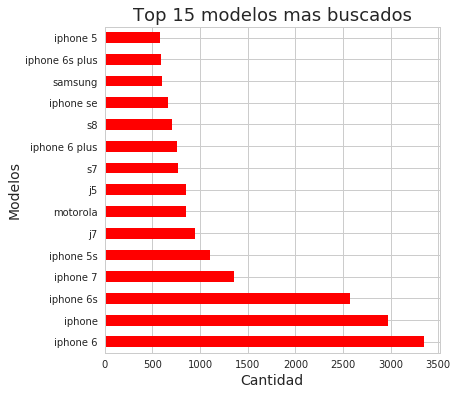

In [79]:
busquedas = searched_products['search_term'].dropna().map(lambda x: x.lower()).value_counts().head(15)
g = plt.subplots(figsize = (6,6))
g = busquedas.plot(kind = 'barh',color='red')
g.set_title('Top 15 modelos mas buscados',fontsize = 18)
g.set_xlabel('Cantidad',fontsize = 14)
g.set_ylabel('Modelos',fontsize = 14);

In [80]:
#el diccionario esta hecho a mano, vi las primeras posiciones y de ahi arme el diccionario, se podria pensar algo mejor. 
#no vi por ahora alguna funcion que haga la que defini, por ahi hay algo hecho pero no encontre
marcas = {'iPhone':['iphone','7s','6s','5se','5c','iphone se'], 'Samsung':['j1','j2','j3','j4','j5','j6','j7','galaxy','s7','s6','s5','s8','s9','samsung'], 'Motorola':['moto'],'LG':['lg']}
def asignar_marca(modelo):
    for marca in marcas:
        for m in marcas[marca]:
            if m in modelo:
                return marca
    return 'Otro'
marcas_buscadas = searched_products['search_term'].dropna().map(lambda x: asignar_marca(x.lower())).value_counts()
marcas_buscadas 

iPhone      18982
Samsung     14659
Otro         8369
Motorola     5773
LG           1184
Name: search_term, dtype: int64

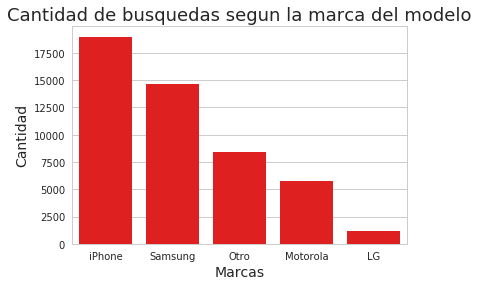

In [81]:
g = sns.barplot(x= marcas_buscadas.index, y=marcas_buscadas.values, orient= 'v',color='red')
g.set_title('Cantidad de busquedas segun la marca del modelo',fontsize = 18)
g.set_xlabel('Marcas',fontsize = 14)
g.set_ylabel('Cantidad',fontsize = 14);

In [83]:
quincenas_busq = searched_products.groupby(['mes', 'dia']).agg({'timestamp':'count'})
quincenas_busq = quincenas_busq.reset_index()
quincenas_busq['quincena'] = np.where(quincenas_busq['dia'] <= 15, '1', '2')
quincenas_busq = quincenas_busq.groupby(['mes', 'quincena']).agg({'timestamp':'sum'})
quincenas_busq.columns = ['busquedas']
quincenas_busq

busquedas
mes quincena           
1   1               407
    2               934
2   1               689
    2               818
3   1              1397
    2              2613
4   1              2923
    2              3838
5   1              9177
    2             16901
6   1             16376

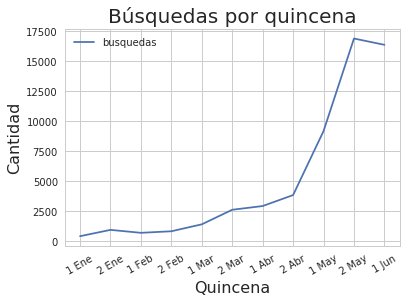

In [84]:
g = quincenas_busq.plot()
g.set_title('Búsquedas por quincena',fontsize = 20)
g.set_xlabel('Quincena',fontsize = 16)
g.set_ylabel('Cantidad',fontsize = 16)
plt.xticks([0,1, 2,3, 4, 5, 6,7,8,9,10], ["1 Ene","2 Ene","1 Feb","2 Feb","1 Mar","2 Mar","1 Abr","2 Abr","1 May",
                                         "2 May","1 Jun"], rotation=30);  

In [85]:
conversion = events[events['event'] == 'conversion']
conversion

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version,dia,mes
220,2018-03-20 17:46:12,conversion,00204059,NaN,3084.0,Motorola Moto X2,Muito Bom,32GB,Couro Vintage,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20,3
2282,2018-04-26 22:28:53,conversion,00c13dee,NaN,6650.0,Samsung Galaxy Core Plus Duos TV,Muito Bom,4GB,Branco,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,4
2547,2018-06-10 14:37:50,conversion,00fdbb4b,NaN,3348.0,Samsung Galaxy S6 Flat,Muito Bom,32GB,Branco,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,6
4245,2018-03-16 13:50:25,conversion,0146a9df,NaN,2694.0,iPhone 5s,Bom,32GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,3
6985,2018-02-09 22:07:07,conversion,01db2fe6,NaN,6357.0,Samsung Galaxy J5,Bom,16GB,Preto,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,2
10005,2018-05-17 02:20:29,conversion,02a6f9b5,NaN,3203.0,Samsung Galaxy A5,Bom,16GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,5
14236,2018-01-09 16:47:50,conversion,03bdcd81,NaN,3301.0,Samsung Galaxy S6 Edge,Excelente,32GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,1
15278,2018-05-15 02:31:34,conversion,042a2a99,NaN,15745.0,LG K10 Novo,Excelente,32GB,Preto,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,5
16800,2018-01-23 22:26:36,conversion,04850add,NaN,2830.0,iPhone 6,Bom,16GB,Cinza espacial,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23,1
18502,2018-01-10 18:59:05,conversion,04fbc241,NaN,6370.0,Samsung Galaxy J5,Muito Bom,16GB,Dourado,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,1


In [88]:
quincenas_comp = conversion.groupby(['mes', 'dia']).agg({'timestamp':'count'})
quincenas_comp = quincenas_comp.reset_index()
quincenas_comp['quincena'] = np.where(quincenas_comp['dia'] <= 15, '1', '2')
quincenas_comp = quincenas_comp.groupby(['mes', 'quincena']).agg({'timestamp':'sum'})
quincenas_comp.columns = ['compras']
quincenas_comp

compras
mes quincena         
1   1              29
    2              34
2   1              40
    2              34
3   1             104
    2             161
4   1             140
    2             176
5   1             247
    2             104
6   1             103

In [94]:
quincenas = quincenas_busq
quincenas['compras'] = quincenas_comp['compras']
quincenas

busquedas  compras
mes quincena                    
1   1               407       29
    2               934       34
2   1               689       40
    2               818       34
3   1              1397      104
    2              2613      161
4   1              2923      140
    2              3838      176
5   1              9177      247
    2             16901      104
6   1             16376      103

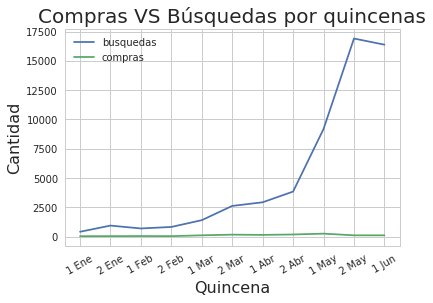

In [97]:
g = quincenas.plot()
g.set_title('Compras VS Búsquedas por quincenas',fontsize = 20)
g.set_xlabel('Quincena',fontsize = 16)
g.set_ylabel('Cantidad',fontsize = 16)
plt.xticks([0,1, 2,3, 4, 5, 6,7,8,9,10], ["1 Ene","2 Ene","1 Feb","2 Feb","1 Mar","2 Mar","1 Abr","2 Abr","1 May",
                                         "2 May","1 Jun"], rotation=30);  

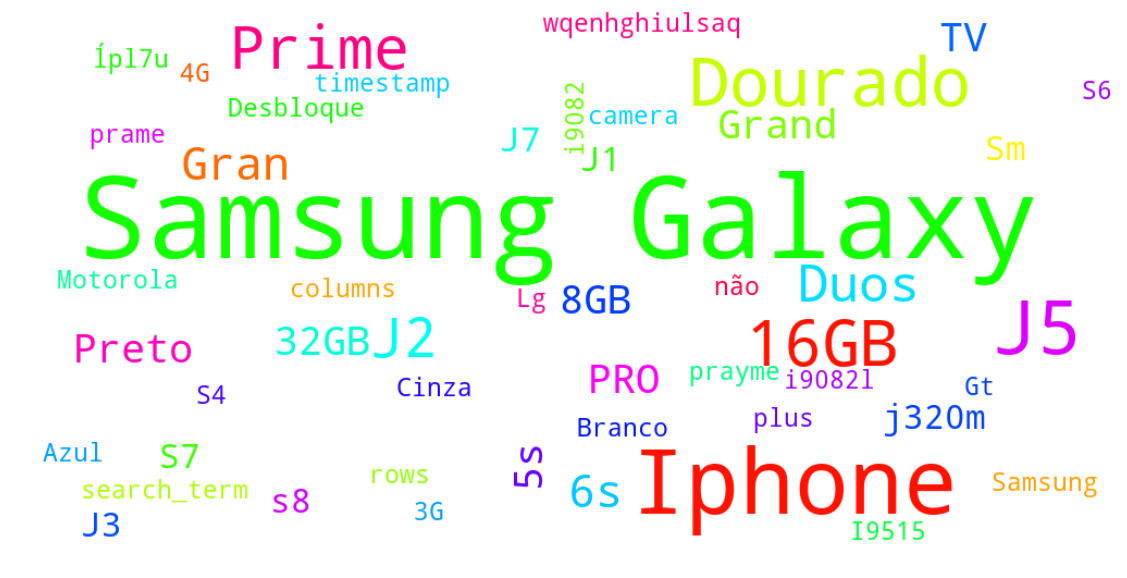

In [12]:
words_df = searched_products.groupby('search_term').agg({'timestamp':'count'}).reset_index().sort_values(by='timestamp', ascending=False)

wordcloud= WordCloud(width=1000, height=500, colormap="hsv", background_color='white').generate(str(words_df))

fig = plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.margins(x=0, y=0)
plt.axis('off')
plt.show()